# Measuring BMI in OpenSAFELY-TPP
This short report describes how BMI can be identified in the OpenSAFELY-TPP database, and the strengths and weaknesses of the methods. This is a living document that will be updated to reflect changes to the OpenSAFELY-TPP database and the patient records within.

## OpenSAFELY
OpenSAFELY is an analytics platform for conducting analyses on Electronic Health Records inside the secure environment where the records are held. This has multiple benefits: 

* We don't transport large volumes of potentially disclosive pseudonymised patient data outside of the secure environments for analysis
* Analyses can run in near real-time as records are ready for analysis as soon as they appear in the secure environment
* All infrastructure and analysis code is stored in GitHub repositories, which are open for security review, scientific review, and re-use

A key feature of OpenSAFELY is the use of study definitions, which are formal specifications of the datasets to be generated from the OpenSAFELY database. This takes care of much of the complex EHR data wrangling required to create a dataset in an analysis-ready format. It also creates a library of standardised and validated variable definitions that can be deployed consistently across multiple projects. 

The purpose of this report is to describe all such variables that relate to BMI, their relative strengths and weaknesses, in what scenarios they are best deployed. It will also describe potential future definitions that have not yet been implemented.

## Available Records
OpenSAFELY-TPP runs inside TPP’s data centre which contains the primary care records for all patients registered at practices using TPP’s SystmOne Clinical Information System. This data centre also imports external datasets from other sources, including A&E attendances and hospital admissions from NHS Digital’s Secondary Use Service, and death registrations from the ONS. More information on available data sources can be found within the OpenSAFELY documentation. 

In [1]:
from IPython.display import display, Markdown

import itertools
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import seaborn as sns

from ebmdatalab import charts
from functools import reduce
from matplotlib import pyplot as plt

plt.rcParams.update({'figure.max_open_warning': 0})

In [2]:
### CONFIGURE OPTIONS HERE ###

# Import file
input_path = '../output/data/input_all.feather'

# Definitions
definitions = ['derived_bmi', 'computed_bmi', 'recorded_bmi']

# Dates
date_min = '2019-01-01'
date_max = '2019-12-31'
time_delta = 'M'

# Min/max range
min_range = 4
max_range = 200

# Null value – 0 or NA
null = 0

# Covariates
demographic_covariates = ['age_band', 'sex', 'ethnicity', 'region', 'imd']
clinical_covariates = ['dementia', 'diabetes', 'hypertension', 'learning_disability']

In [3]:
def redact_round_table(df_in):
    """Redacts counts <= 5 and rounds counts to nearest 5"""
    df_out = df_in.where(df_in > 5, np.nan).apply(lambda x: 5 * round(x/5))
    return df_out

In [4]:
# Import
df_import = pd.read_feather(input_path)
# Subset to relevant columns
df_clean = df_import[['patient_id', 'date'] + definitions + demographic_covariates + clinical_covariates]
# Limit to relevant date range
df_clean = df_clean.loc[(date_min <= df_clean.date) & (df_clean.date <= date_max)].sort_values(by='patient_id').reset_index(drop=True)
# Set null values to nan
for definition in definitions: 
    df_clean.loc[df_clean[definition] == null, definition] = np.nan
 # Create order for categorical variables
for group in demographic_covariates + clinical_covariates:
    if df_clean[group].dtype.name == 'category':
        li_order = sorted(df_clean[group].dropna().unique().tolist())
        df_clean[group] = df_clean[group].cat.reorder_categories(li_order, ordered=True)
# Mark patients with value filled/missing for each definition
for definition in definitions:
    df_clean.loc[~df_clean[definition].isna(), definition+"_filled"] = 1
    df_clean.loc[df_clean[definition].isna(), definition+"_missing"] = 1

In [5]:
# All population
li_pop = []
for definition in definitions:
    df_temp = df_clean[['patient_id']].drop_duplicates().set_index('patient_id')
    df_temp[definition+'_filled'] = 1
    li_pop.append(df_temp)
    
df_temp0 = pd.concat(li_pop)
df_pop = pd.DataFrame(df_temp0.sum()).T
df_pop['group'],df_pop['subgroup'] = ['population','N']
df_pop = df_pop.set_index(['group','subgroup'])

# All with measurement
li_filled = []
for definition in definitions:
    df_temp = df_clean[['patient_id', definition+'_filled']].drop_duplicates().dropna().set_index('patient_id')
    li_filled.append(df_temp)
    
df_temp2 = pd.concat(li_filled, axis=1)
df_all = pd.DataFrame(df_temp2.sum()).T
df_all['group'],df_all['subgroup'] = ['population','with records']
df_all = df_all.set_index(['group','subgroup'])

# By group
li_group = []
for group in demographic_covariates + clinical_covariates:
    li_filled_group = []
    for definition in definitions:
        df_temp = df_clean[['patient_id', definition+'_filled', group]].drop_duplicates().dropna().reset_index(drop=True)
        li_filled_group.append(df_temp)
    df_reduce = reduce(lambda df1, df2: pd.merge(df1, df2,on=['patient_id',group],how='outer'), li_filled_group)
    df_reduce2 = df_reduce.sort_values(by=group).drop(columns=['patient_id']).groupby(group).sum().reset_index()
    df_reduce2['group'] = group
    df_reduce2 = df_reduce2.rename(columns={group:'subgroup'})
    li_group.append(df_reduce2)
df_all_group = pd.concat(li_group, axis=0, ignore_index=True).set_index(['group','subgroup'])
df_all_ct = df_pop.append([df_all,df_all_group])

# Redact
df_all_redact = redact_round_table(df_all_ct)

# Create percentage columns 
for definition in definitions:
    df_all_redact[definition+'_pct'] = round((df_all_redact[definition+"_filled"].div(df_all_redact[definition+"_filled"][0]))*100,1)

df_all_redact = df_all_redact[['derived_bmi_filled','derived_bmi_pct','computed_bmi_filled','computed_bmi_pct','recorded_bmi_filled','recorded_bmi_pct']]
df_all_redact = df_all_redact.where(~df_all_redact.isna(), '-')

## Methods
 
We define three variable phenotypes: computed, recorded, and derived BMI. 
* Computed BMI refers to BMI calculated from height and weight measurements. 
* Recorded BMI refers to coded events of BMI. 
* Derived BMI refers to the canonical definition used in the OpenSAFELY backend using the `most_recent_bmi()` function, which returns patients' most recent BMI (in the defined period) either computed from weight and height measurements or, where they are not availble, from recorded BMI values.

We examine how well each of these phenotypes are populated, looking at the whole population and across demographic and clinical subgroups to detect any inequalities.

## Results

### Count of Patients

In [6]:
df_all_redact

derived_bmi_filled  \
group               subgroup                                       
population          N                                       7175   
                    with records                            6290   
age_band            0-19                                    1190   
                    20-29                                   1115   
                    30-39                                   1175   
                    40-49                                   1115   
                    50-59                                   1030   
                    60-69                                   1125   
                    70-79                                   1165   
                    80+                                     1150   
sex                 F                                       3910   
                    M                                       3830   
ethnicity           1                                        330   
                    2                                        160   
                    3                                         70   
                    4                                         35   
                    5                                         20   
                    6                                         10   
                    7                                          5   
                    8                                          5   
region              East Midlands                            595   
                    East of England                          600   
                    London                                  1175   
                    North East                               620   
                    North West                               575   
                    South East                              1185   
                    West Midlands                            630   
                    Yorkshire and the Humber                 610   
imd                 100                                     1750   
                    200                                     1800   
                    300                                     1755   
                    400                                     1765   
                    500                                     1730   
dementia            False                                   6255   
                    True                                     100   
diabetes            False                                   6255   
                    True                                      95   
hypertension        False                                   6260   
                    True                                     100   
learning_disability False                                   6255   
                    True                                      85   

                                             derived_bmi_pct  \
group               subgroup                                   
population          N                                  100.0   
                    with records                        87.7   
age_band            0-19                                16.6   
                    20-29                               15.5   
                    30-39                               16.4   
                    40-49                               15.5   
                    50-59                               14.4   
                    60-69                               15.7   
                    70-79                               16.2   
                    80+                                 16.0   
sex                 F                                   54.5   
                    M                                   53.4   
ethnicity           1                                    4.6   
                    2                                    2.2   
                    3                                    1.0   
                    4            

### Count of Missings

In [7]:
# All population
li_pop = []
for definition in definitions:
    df_temp = df_clean[['patient_id']].drop_duplicates().set_index('patient_id')
    df_temp[definition+'_missing'] = 1
    li_pop.append(df_temp)
    
df_temp0 = pd.concat(li_pop)
df_pop = pd.DataFrame(df_temp0.sum()).T
df_pop['group'],df_pop['subgroup'] = ['population','N']
df_pop = df_pop.set_index(['group','subgroup'])

# All with measurement
li_missing = []
for definition in definitions:
    df_temp = df_clean[['patient_id', definition+'_missing']].drop_duplicates().dropna().set_index('patient_id')
    li_missing.append(df_temp)
    
df_temp3 = pd.concat(li_missing, axis=1)
df_miss = pd.DataFrame(df_temp3.sum()).T
df_miss['group'],df_miss['subgroup'] = ['population','missing records']
df_miss = df_miss.set_index(['group','subgroup'])

# By group
li_group = []
for group in demographic_covariates + clinical_covariates:
    li_missing_group = []
    for definition in definitions:
        df_temp = df_clean[['patient_id', definition+'_missing', group]].drop_duplicates().dropna().reset_index(drop=True)
        li_missing_group.append(df_temp)
    df_reduce = reduce(lambda df1, df2: pd.merge(df1, df2,on=['patient_id',group],how='outer'), li_missing_group)
    df_reduce2 = df_reduce.sort_values(by=group).drop(columns=['patient_id']).groupby(group).sum().reset_index()
    df_reduce2['group'] = group
    df_reduce2 = df_reduce2.rename(columns={group:'subgroup'})
    li_group.append(df_reduce2)
df_miss_group = pd.concat(li_group).set_index(['group','subgroup'])
df_miss_ct = df_pop.append([df_miss,df_miss_group])

# Redact
df_miss_redact = redact_round_table(df_miss_ct)

# Create percentage columns 
for definition in definitions:
    df_miss_redact[definition+'_pct'] = round((df_miss_redact[definition+"_missing"].div(df_miss_redact[definition+"_missing"][0]))*100,1)
    
df_miss_redact = df_miss_redact[['derived_bmi_missing','derived_bmi_pct','computed_bmi_missing','computed_bmi_pct','recorded_bmi_missing','recorded_bmi_pct']]
df_miss_redact = df_miss_redact.where(~df_miss_redact.isna(), '-')

In [8]:
df_miss_redact

derived_bmi_missing  \
group               subgroup                                       
population          N                                     7175.0   
                    missing records                       2130.0   
age_band            0-19                                   315.0   
                    20-29                                  305.0   
                    30-39                                  310.0   
                    40-49                                  285.0   
                    50-59                                  275.0   
                    60-69                                  280.0   
                    70-79                                  300.0   
                    80+                                    280.0   
sex                 F                                     1120.0   
                    M                                     1140.0   
ethnicity           1                                      110.0   
                    2                                       55.0   
                    3                                       30.0   
                    4                                       15.0   
                    5                                       10.0   
                    6                                          -   
                    7                                          -   
                    8                                          -   
region              East Midlands                          130.0   
                    East of England                        165.0   
                    London                                 315.0   
                    North East                             150.0   
                    North West                             165.0   
                    South East                             305.0   
                    West Midlands                          165.0   
                    Yorkshire and the Humber               135.0   
imd                 100                                    440.0   
                    200                                    490.0   
                    300                                    470.0   
                    400                                    475.0   
                    500                                    470.0   
dementia            False                                 2115.0   
                    True                                    15.0   
diabetes            False                                 2110.0   
                    True                                    25.0   
hypertension        False                                 2115.0   
                    True                                    20.0   
learning_disability False                                 2100.0   
                    True                                    35.0   

                                             derived_bmi_pct  \
group               subgroup                                   
population          N                                  100.0   
                    missing records                     29.7   
age_band            0-19                                 4.4   
                    20-29                                4.3   
                    30-39                                4.3   
                    40-49                                4.0   
                    50-59                                3.8   
                    60-69                                3.9   
                    70-79                                4.2   
                    80+                                  3.9   
sex                 F                                   15.6   
                    M                                   15.9   
ethnicity           1                                    1.5   
                    2                                    0.8   
                    3                                    0.4   
                    4           

### Overlapping Definitions

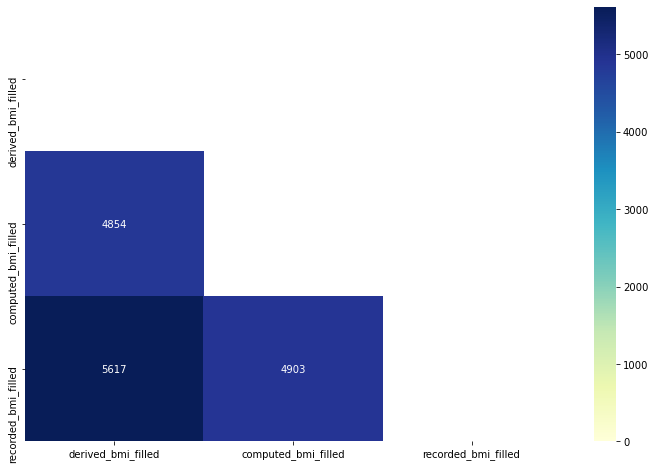

In [17]:
df_transform = df_temp2.replace(np.nan,0)
df_dot = df_transform.T.dot(df_transform)
mask = np.triu(np.ones_like(df_dot))

# Draw the heatmap with the mask
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df_dot, mask=mask, annot=True, fmt='g', cmap="YlGnBu", vmin=0)
plt.show()

### Number of Patients Over Time

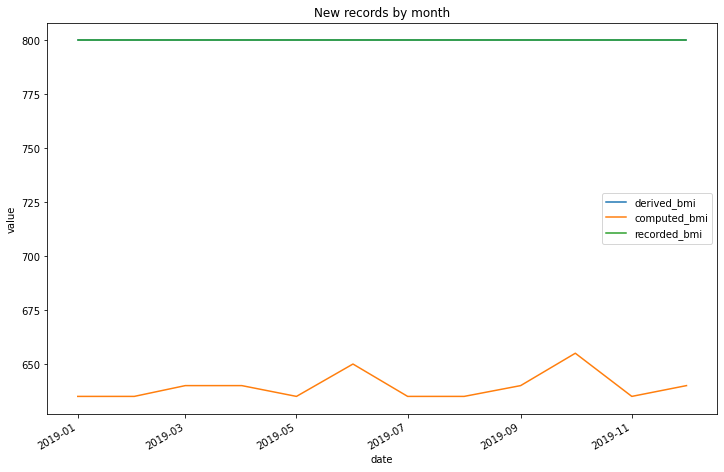

In [10]:
df_all_time = redact_round_table(df_clean[['date'] + definitions].groupby('date').count())
df_all_time = df_all_time.stack().reset_index().rename(columns={'level_1':'variable',0:'value'})
fig, ax = plt.subplots(figsize=(12, 8))
fig.autofmt_xdate()
sns.lineplot(x = 'date', y = 'value', hue='variable', data = df_all_time, ax=ax).set_title('New records by month')
ax.legend().set_title('')

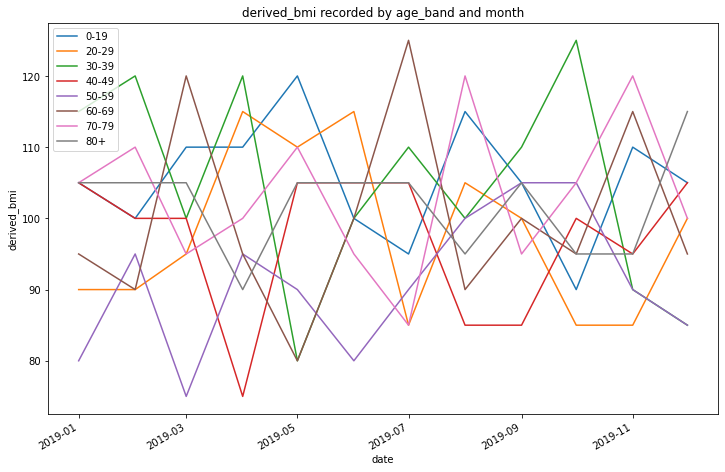

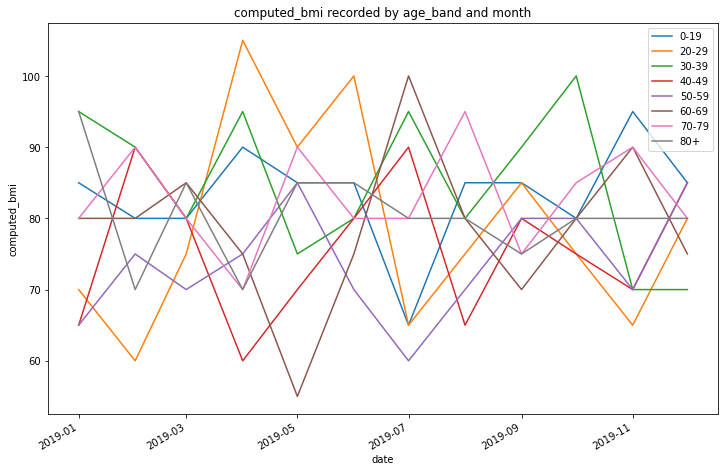

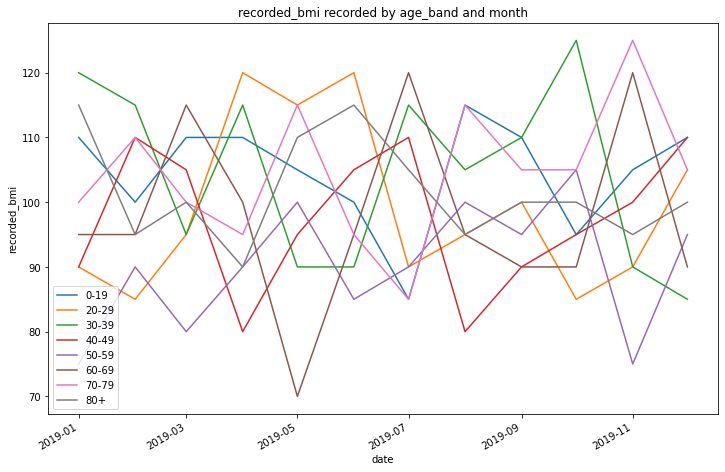

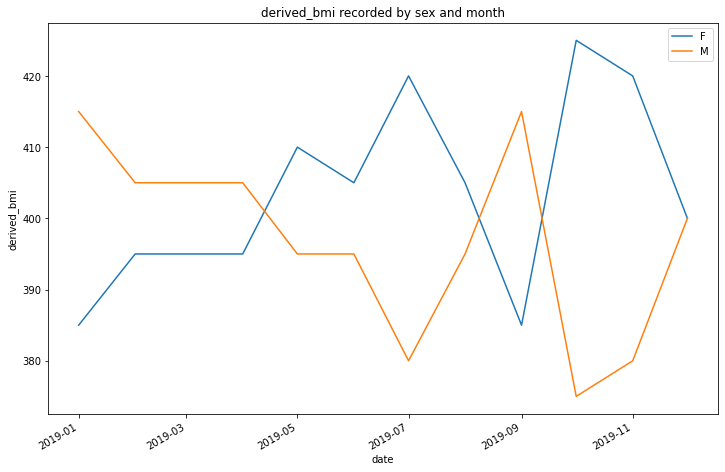

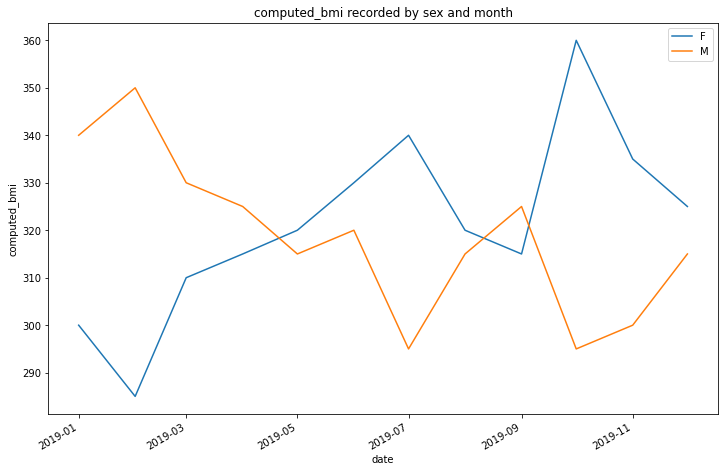

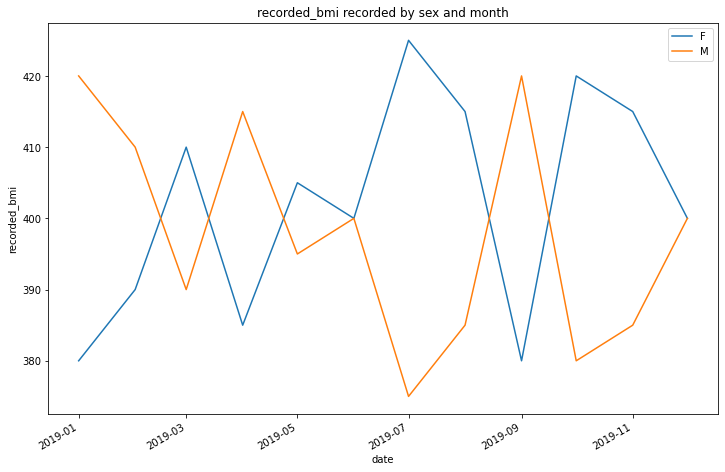

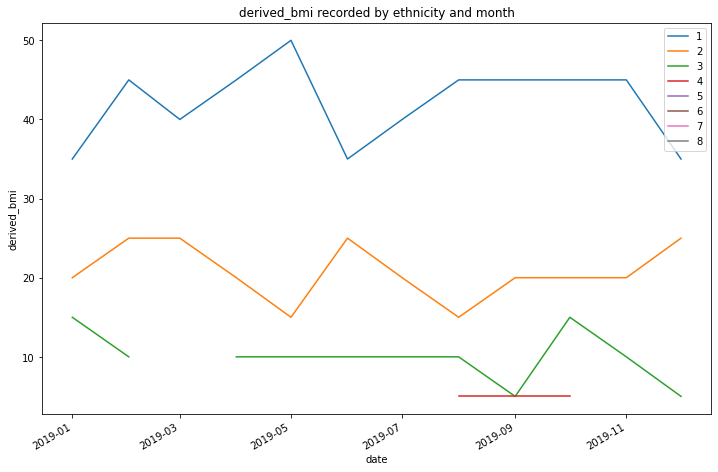

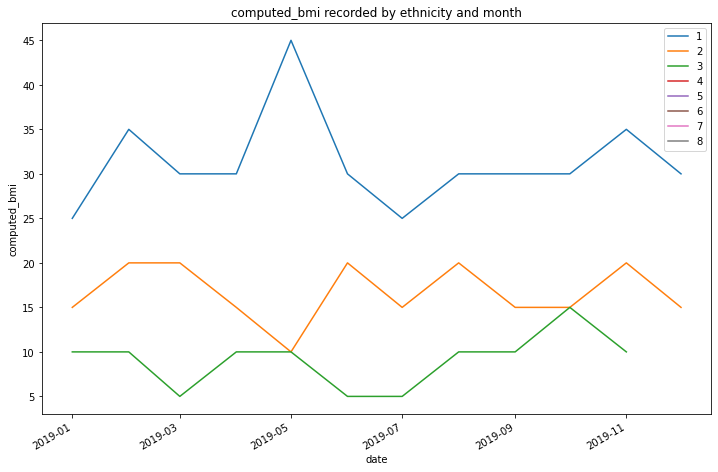

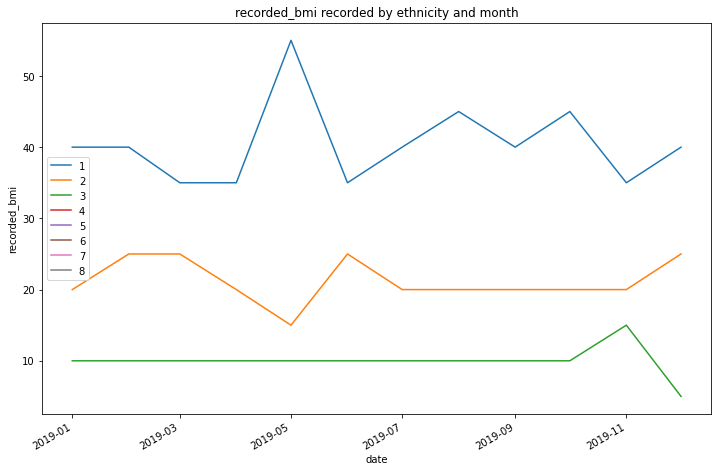

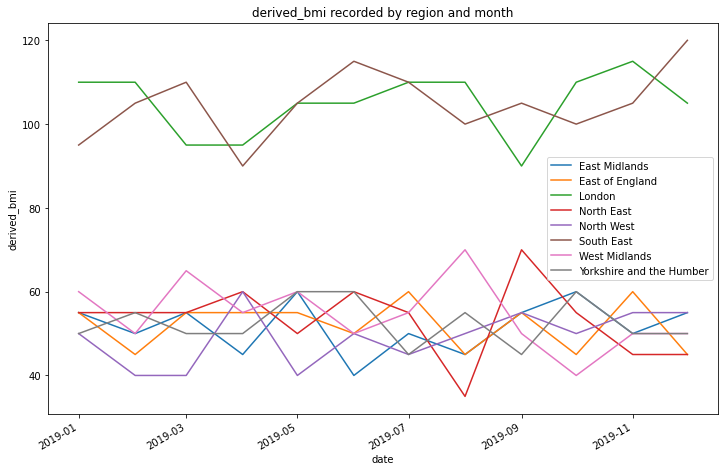

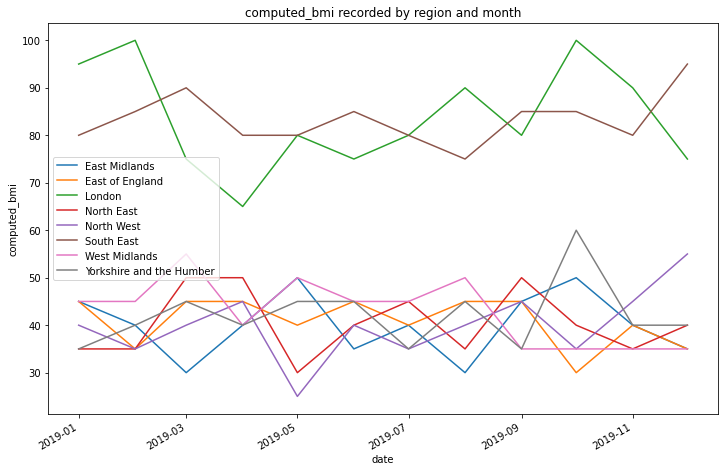

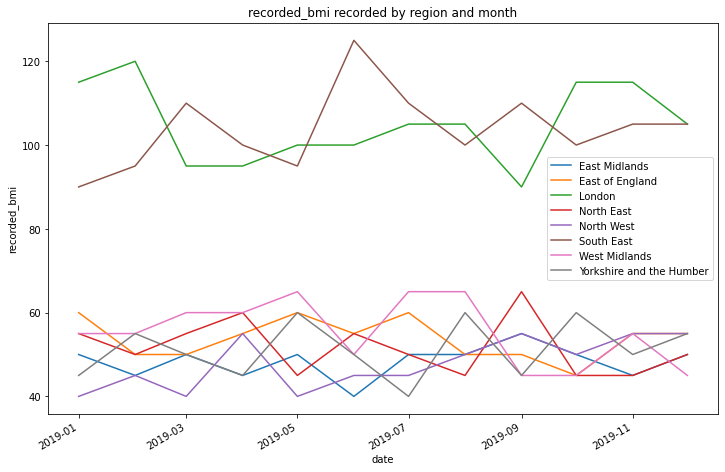

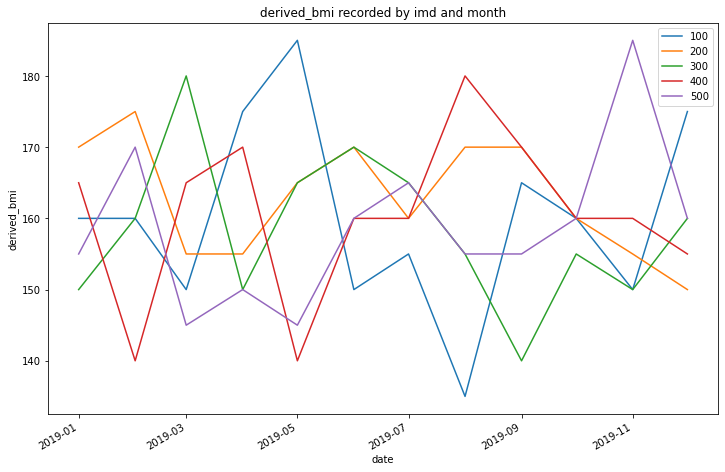

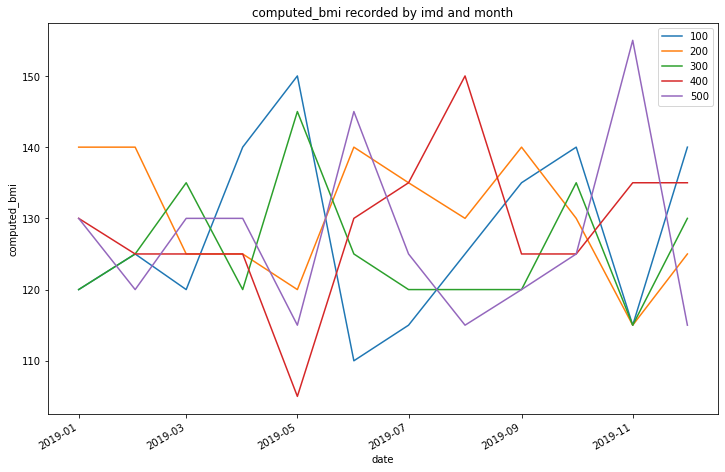

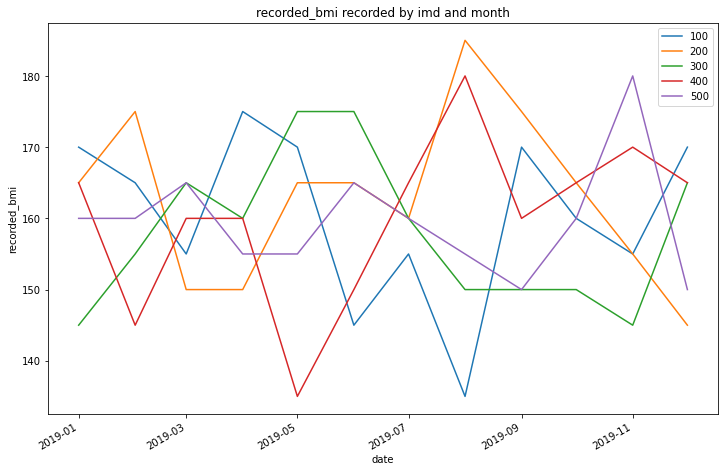

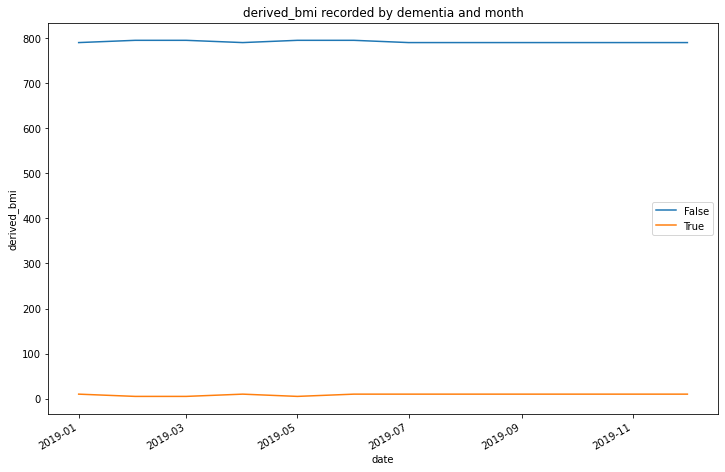

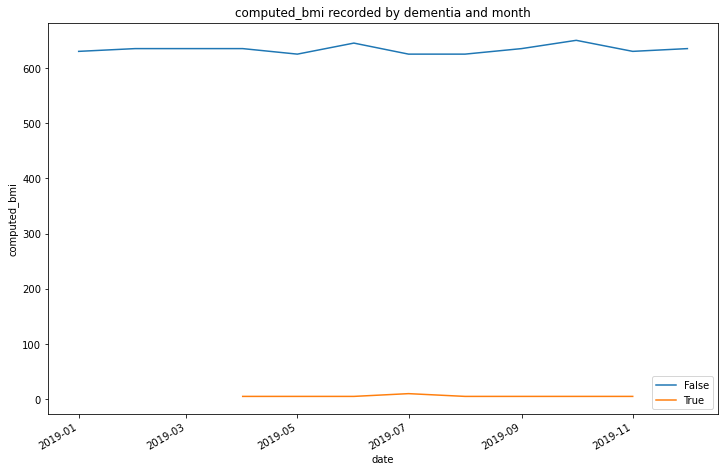

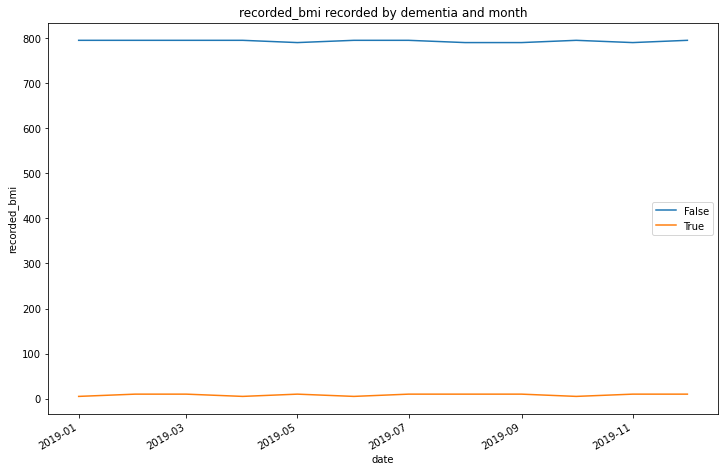

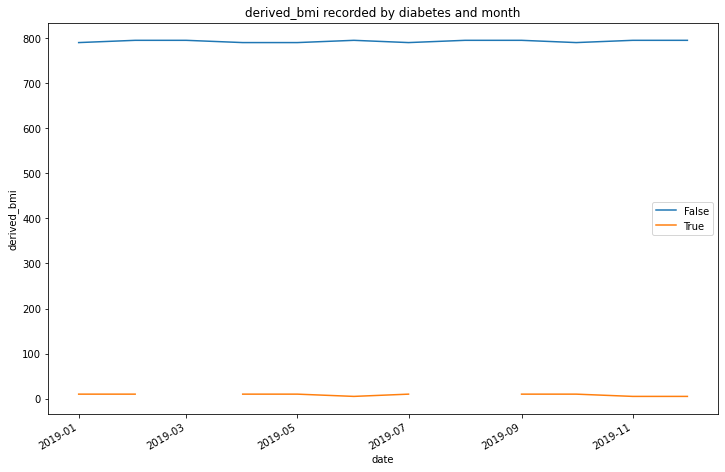

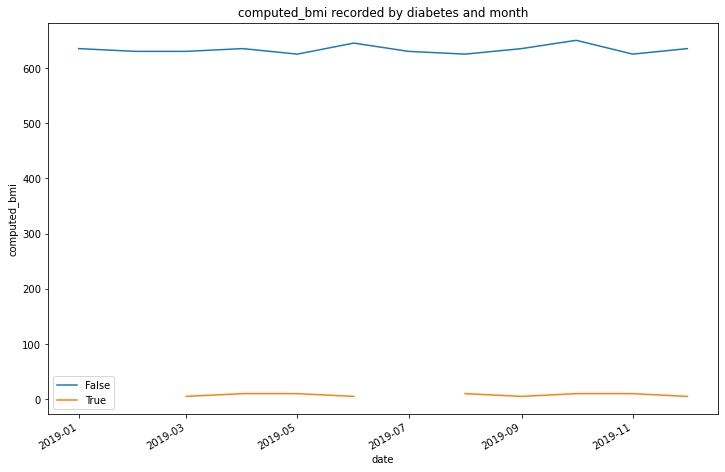

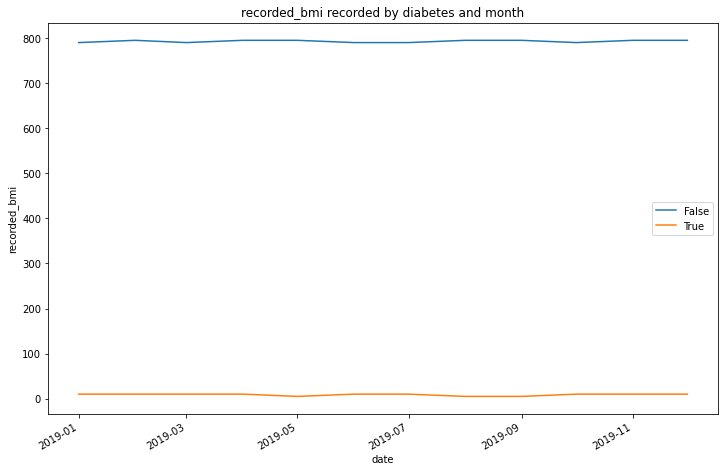

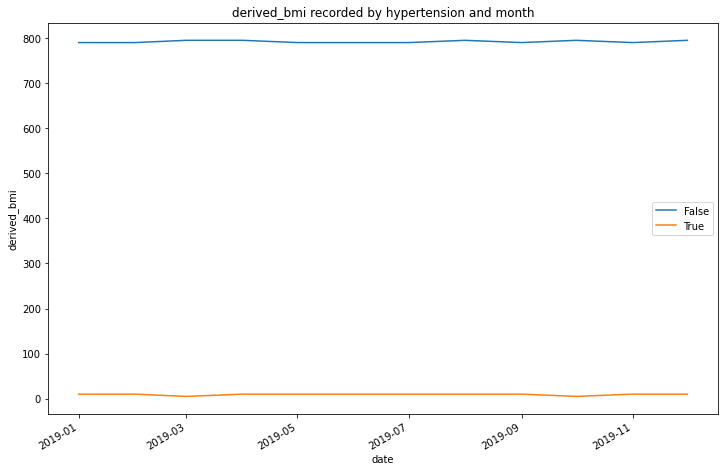

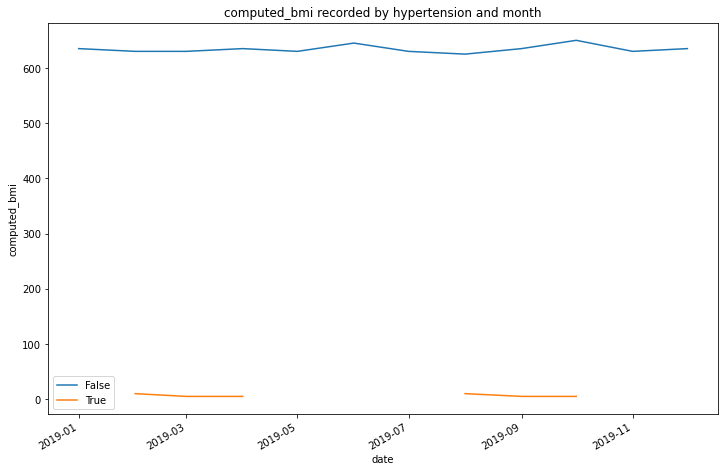

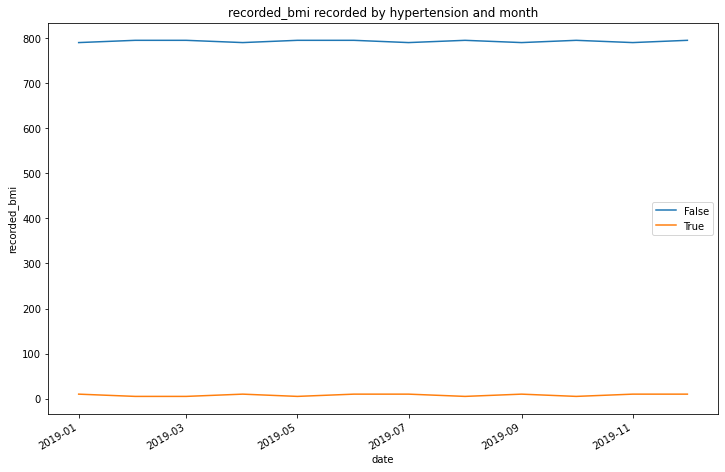

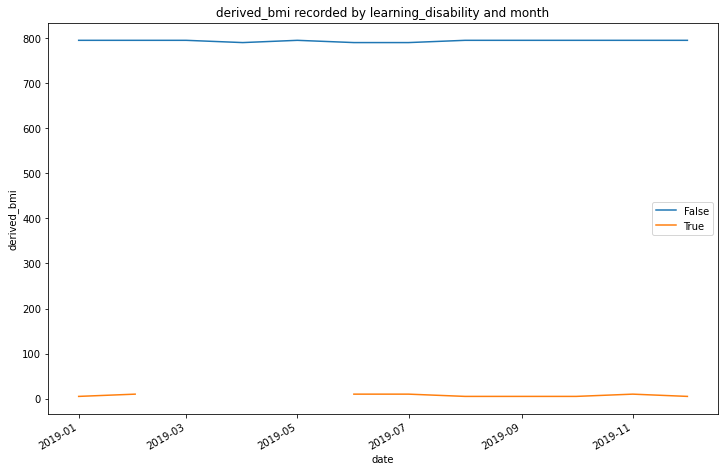

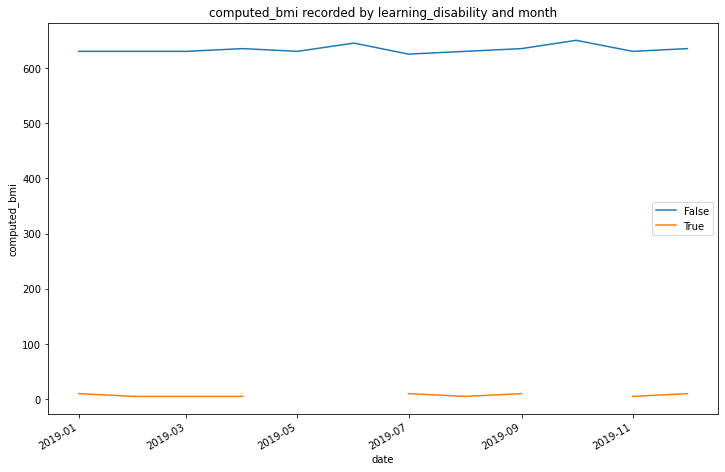

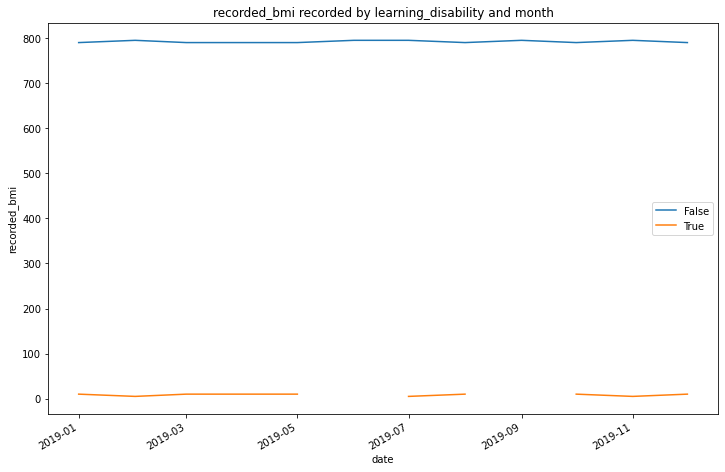

In [11]:
for group in demographic_covariates + clinical_covariates:
    for definition in definitions: 
        df_time = redact_round_table(df_clean[['date',group,definition]].groupby(['date',group]).count()).reset_index()
        df_time = df_time.replace('-',np.nan)
        fig, ax = plt.subplots(figsize=(12, 8))
        fig.autofmt_xdate()
        sns.lineplot(x = 'date', y = definition, hue=group, data = df_time, ax=ax).set_title(f'{definition} recorded by {group} and month')
        ax.legend().set_title('')